In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = 'puzzles.db'
conn = sqlite3.connect(db_path)

In [5]:
query = "SELECT length FROM solutions;"
df = pd.read_sql_query(query, conn)

length_counts = df['length'].value_counts().sort_index()

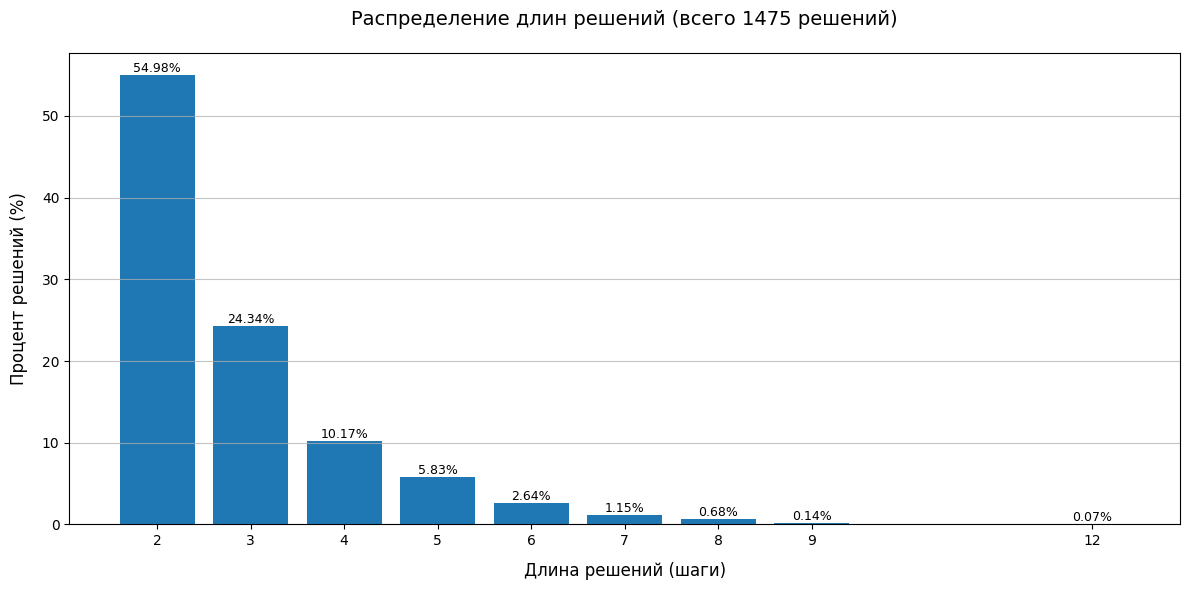

In [6]:
plt.figure(figsize=(12, 6))

total = length_counts.sum()
length_percent = (length_counts / total) * 100

bars = plt.bar(length_percent.index, length_percent.values)  # type: ignore

plt.title(f'Распределение длин решений (всего {total} решений)', pad=20, fontsize=14)
plt.xlabel('Длина решений (шаги)', fontsize=12, labelpad=10)
plt.ylabel('Процент решений (%)', fontsize=12, labelpad=10)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', 
             va='bottom',
             fontsize=9)

plt.xticks(
    length_percent.index,
    fontsize=10
)

plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()